# Monet-Style Image Generation by Generative Adversarial Networks (GANs)

### Problem Description

In this project we are trying to generate Claude Monet-styled images by training a generative adversarial network (GAN) to discriminate between real and fake Monets. The data/contest/problem description is available at https://www.kaggle.com/competitions/gan-getting-started/overview. Also, a great tutorial on the CycleGAN algorithm that was heavily relied on can be found at https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial.

The dataset has 300 real Monet paintings with which to train the model, and 7,028 photos with which to add Monet-styling to from the trained model. The data is provided in both jpeg and Tfrec (Tensor-Flow records) format. We will used the Tfrec format in this notebook.

## 0) Setup

### Import Required Libraries

In [1]:
import numpy as np
import math
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### Data Preparation and Cleaning

This simply discovers the tfrecords in our working directory. Note that the record count is a little misleading - the tfrec files contain multiple images, so the 300/7028 count mentioned above still holds.

In [2]:
MONET_FILENAMES = tf.io.gfile.glob(str('./gan-getting-started/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str('./gan-getting-started/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Let's set up some functions to read the image records from the tfrec files. We are told that all images are already sized to 256x256, and also we'll be working with the 3 RGB channels. Additionally, because GANs generally (and ours will as well) use the tanh function in the generator so that output is defined in a practical range, we then also need to scale the data images to a [-1, 1] scale so that they match what we will be outputting in the generator. See the notes in the methods below.

In [30]:
IMAGE_SIZE = [256, 256]
RGB_CHANNELS = 3

def decode_image(image):
    # This method decodes image to a uint8 tensor
    image = tf.image.decode_jpeg(image, channels=RGB_CHANNELS)
    # Here is where we normalize to [-1 1] by dividing by 128 (be careful to cast to float!) and subtracting 1
    image = (tf.cast(image, tf.float32) / 128) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, RGB_CHANNELS])
    return image

def read_tfrecord(example):
    # Configure the tfrecord format
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    # Parse the record
    example = tf.io.parse_single_example(example, tfrecord_format)
    # Forget everything except that actual image
    image = decode_image(example['image'])
    return image

# Now this is the top-level data loading function
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

## 1) Exploratory Data Analysis (EDA)

There's not a whole lot of exploratory data analysis we can do here when compared to, say, typical data for a supervised learning problem, for example. So our EDA will mostly be limited to visualizing some of the data we are going to be working with here. So for now let's load in the datasets, one which is the real Monet paintings, and the other real photos.

In [4]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Extract an example of each dataset to visualize

In [5]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Store a tenor size for later use. This also to some degree "proves" that we really are working with 256x256 images with 3 RGB channels.

In [6]:
TENSOR_SIZE = example_monet[0].shape
print(TENSOR_SIZE)

(256, 256, 3)


Now let's visualize a photo example and a Monet example. The Monet is what we expect from having any familiarity with the artist - a plein air Impressionist painting with visible brush strokes.

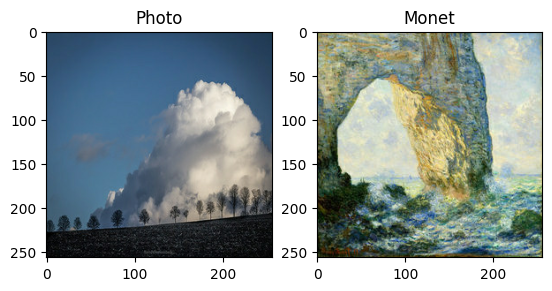

In [7]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## 1) Model Building

#### Build the generator

We'll be using a UNTE inspireT architecture for our CycleGAN .A good inrtoduction to UNET can be found here https://paperswithcode.com/method/u-nets Essentially, it consists of contracting (downsampling) and expansive (upsampling) layers. I don't follow the UNET architectureperfectlyy, for example in the use of strides in the convolutional layers rather than max pooling to handle theup/down  resizings, under the hypothesis that the harsher spatial downsampling imposed by max pooling might cause the loss of more subtle features in the modle. With that in mind, here is a visual representation of the traditiona/publishedl UNET architecturs.

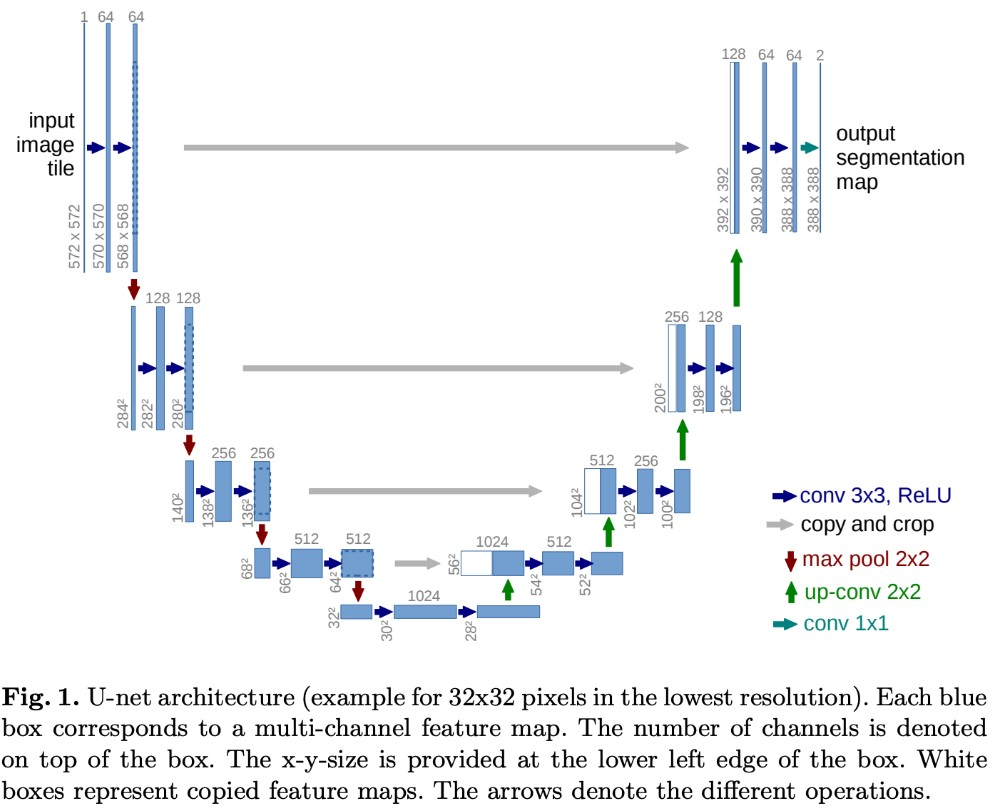

In [8]:
from PIL import Image
pil_im = Image.open('UNETArchitecture.jpg')
display(pil_im)

In [9]:
# RGB output channels
OUTPUT_CHANNELS = 3

Here is a function that implements a downsampling layer.

In [10]:
def Conv2D_downsample_layer(filters, size, apply_instancenorm=True):
    # Create sequential model
    result = keras.Sequential()
    
    # Add conv2d layer
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=keras.initializers.HeNormal(), use_bias=False))
    
    # Normalize
    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(groups=-1, gamma_initializer=keras.initializers.RandomNormal()))

    # Activate with leakyReLU
    result.add(layers.LeakyReLU())

    return result

Upsample does the opposite of downsample and increases the dimensions of the of the image. Conv2DTranspose does basically the opposite of a Conv2D layer.

In [11]:
def Conv2D_upsample_layer(filters, size, apply_dropout=False):
    # Create sequential model
    result = keras.Sequential()

    # Add conv2d-transpose layer
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=keras.initializers.HeNormal(), use_bias=False))

    # Normalize
    result.add(tf.keras.layers.GroupNormalization(groups=-1, gamma_initializer=keras.initializers.RandomNormal()))

    # Dropout
    if apply_dropout:
        result.add(layers.Dropout(0.5))

    # Activate with leakyReLU
    result.add(layers.ReLU())

    return result

Now let's build the generator. Following (again, loosely) the UNET architecture, the generator first downsamples the input image and then upsamples while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [12]:
def Generator():
    inputs = layers.Input(shape=TENSOR_SIZE)

    # Find how many times TENSOR_SIZE can be halved before 1 is left
    max_iters = int(math.log2(TENSOR_SIZE[0]))

    down_stack = []
    for i in range(max_iters):
        iter_norm = False if i == 0 else True
        down_stack.append(Conv2D_downsample_layer(64, 4, apply_instancenorm=iter_norm))

    up_stack = []
    for i in range(max_iters - 1):
        iter_dropout = True if i < 3 else False
        up_stack.append(Conv2D_upsample_layer(64, 4, apply_dropout=iter_dropout))

    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=keras.initializers.RandomNormal(), activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

#### Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [14]:
def Discriminator():

    inp = layers.Input(shape=TENSOR_SIZE, name='input_image')

    x = inp

    down1 = Conv2D_downsample_layer(64, 3, False)(x)
    down2 = Conv2D_downsample_layer(64, 3)(down1)
    down3 = Conv2D_downsample_layer(64, 3)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(64, 3, strides=1, kernel_initializer=keras.initializers.HeNormal(), use_bias=False)(zero_pad1)

    norm1 = tf.keras.layers.GroupNormalization(groups=-1, gamma_initializer=keras.initializers.RandomNormal())(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 3, strides=1, kernel_initializer=keras.initializers.HeNormal())(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

#### Initialize Generators and Discriminators

So now let's just instantiate some generators and discriminators for the Monets and the photos.

In [15]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

Since the generators are not trained yet, the generated Monet-style photo shows an initial, basically nonsense state.

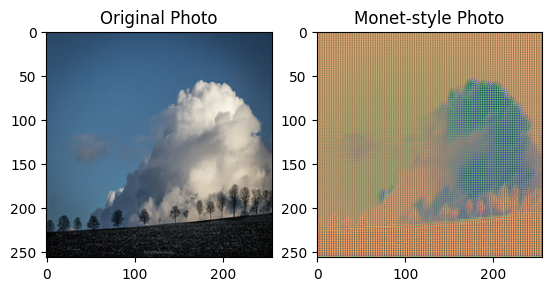

In [16]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-style Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## 2) Training the UNET Model in a CycleGAN Algorithm
Now let's build a CycleGAN class, which importantly takes in aa tf.keras.Model so that we can run fit() later to trainther model.Recall that the CycleGAN algorithm essentially means that dDuringae training step, the model transforms a photo(in this case  to a Mone-stylet paintin),g and the transforms itn back to a phot (so it "cycles")o. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one anotheron.

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [18]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [19]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [20]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [21]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

#### Fit the CycleGAN

Let's compile our model. Since we used tf.keras.Model to build our CycleGAN, we can just sde the fit function to train our model.

In [22]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [24]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 151ms/step - monet_disc_loss: 0.6610 - monet_gen_loss: 4.9697 - photo_disc_loss: 0.6711 - photo_gen_loss: 5.0794
Epoch 2/25


C:\Program Files\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - monet_disc_loss: 0.6643 - monet_gen_loss: 3.1069 - photo_disc_loss: 0.6702 - photo_gen_loss: 3.1553
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - monet_disc_loss: 0.6380 - monet_gen_loss: 2.8580 - photo_disc_loss: 0.6538 - photo_gen_loss: 2.8758
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - monet_disc_loss: 0.5826 - monet_gen_loss: 2.8388 - photo_disc_loss: 0.6448 - photo_gen_loss: 2.7550
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - monet_disc_loss: 0.5205 - monet_gen_loss: 2.9289 - photo_disc_loss: 0.6388 - photo_gen_loss: 2.6836
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - monet_disc_loss: 0.5381 - monet_gen_loss: 2.8935 - photo_disc_loss: 0.6349 - photo_gen_loss: 2.6280
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - monet_disc_loss: 0.4477 - monet_gen_loss: 3.1463 - photo_disc_loss: 0.6324 - photo_gen_loss: 2.5947
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - monet_disc_l

### Visualize some Monet-styled Photos

Now we can used the calibrated model to transform some of the photos we were given. You can definitely see the Monet-y style in the transformed images. It's not spectacular - I don't know if any would really pass as a Monet to a human even slightly familiar with his work, but the results are cool nevertheless.

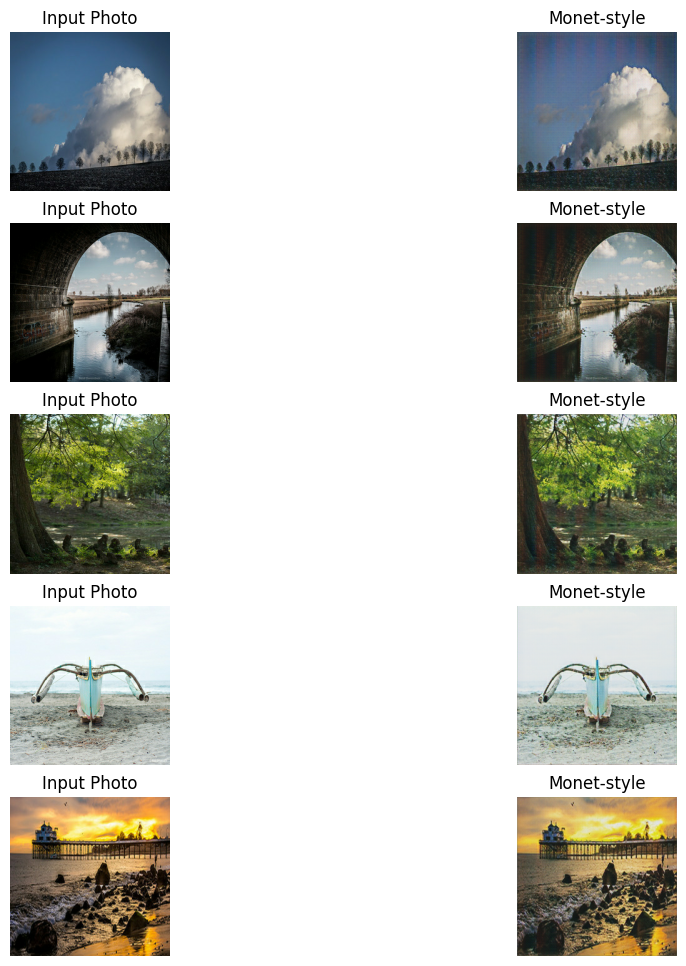

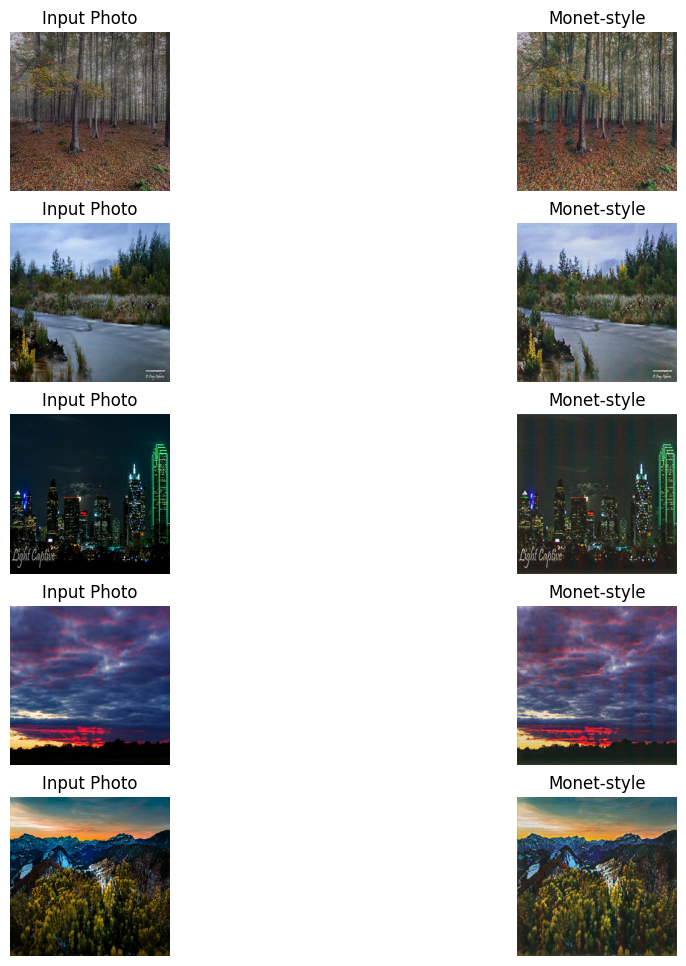

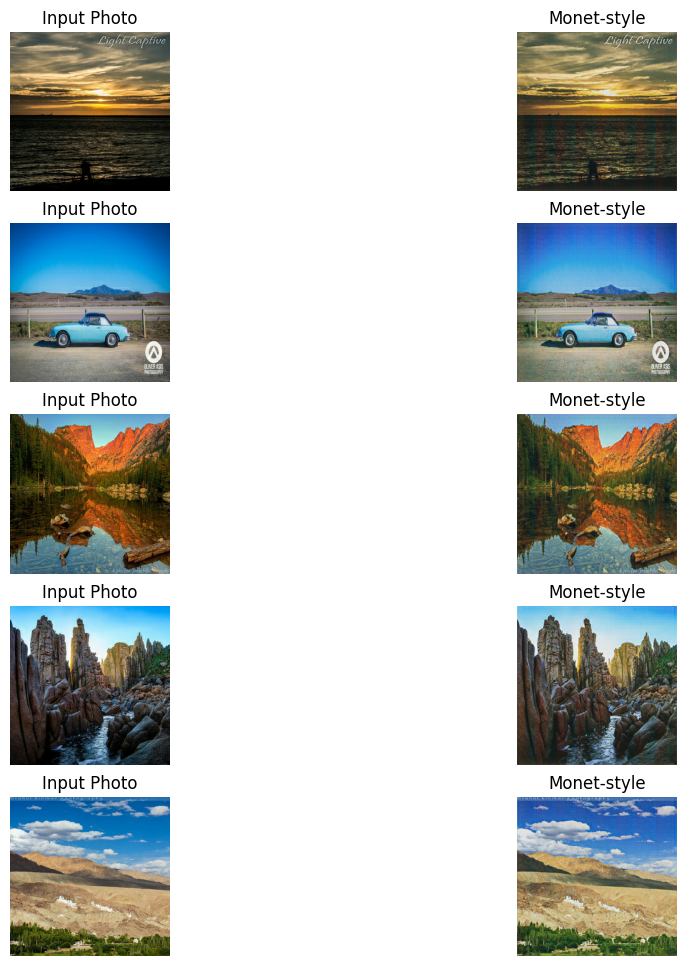

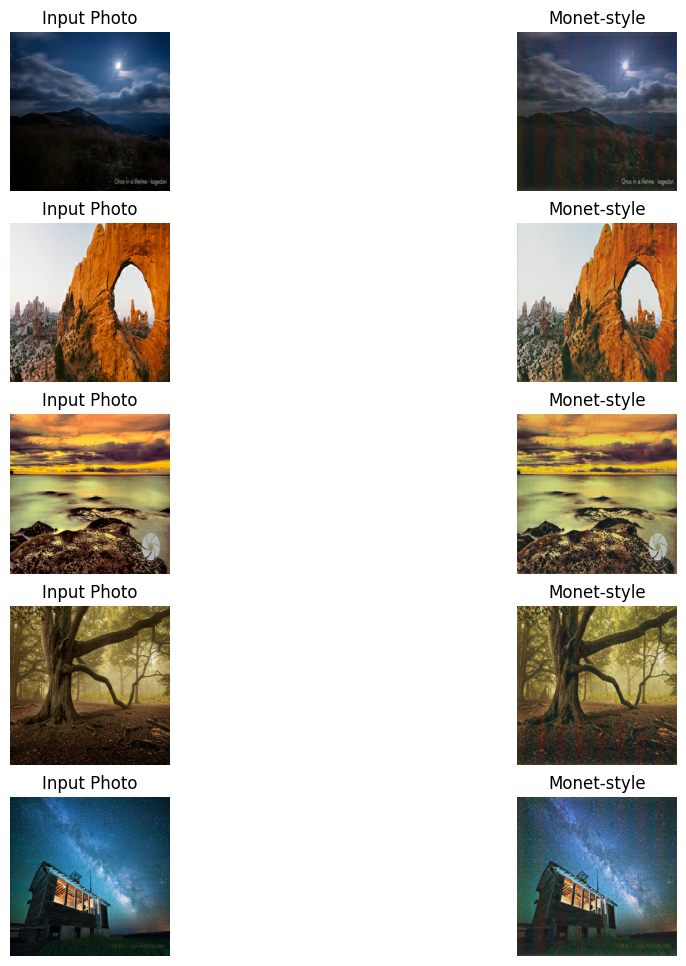

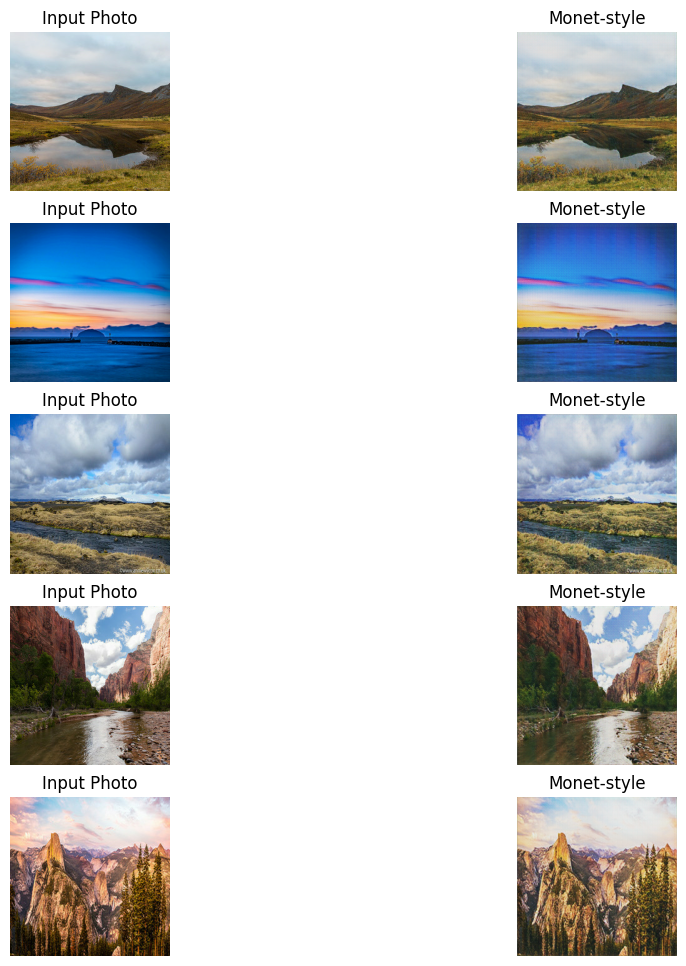

In [25]:
for z in range(5):
    _, ax = plt.subplots(5, 2, figsize=(12, 12))
    for i, img in enumerate(photo_ds.skip(z * 5).take(5)):
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 128 + 128).astype(np.uint8)
        img = (img[0] * 128 + 128).numpy().astype(np.uint8)
    
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-style")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

### Create submission file

In [27]:
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 128 + 128).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

The syntax of the command is incorrect.


In [28]:
import shutil
shutil.make_archive("./images", 'zip', "images")

'C:\\Users\\zackp\\source\\repos\\CSMasters\\CSMasters\\Intro to Deep Learning\\Week5_Project\\images.zip'

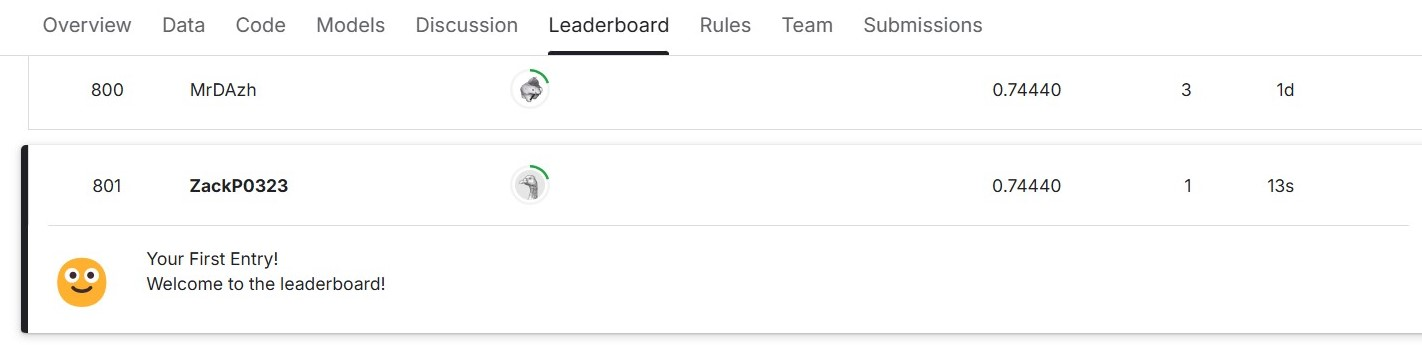

In [29]:
pil_im = Image.open('Leaderboard_Screenshot.jpg')
display(pil_im)

## 3) Conclusion

In this workbook a CycleGAN algorithm was used to train a UNET-ish model as a means of transforming photos to mimic Monet-style paintings. Keras was relied upon, and the Sequential layering capabilities particuarly (i.e. convolutions, activations, etc) as well as the calibration (fit). Overall the results are interesting and clearly wokring to achieve the results intended. In this case a single rather arbitray model (meaning hyperparameter choices) was used, so tuning could likely lead to more promising results.